In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle
from photutils.aperture import SkyCircularAperture 
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.psf import fit_fwhm
from astropy.visualization import simple_norm
from pathlib import Path
import re
import pandas as pd
from photutils.aperture import ApertureStats
from photutils.datasets import make_wcs
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic,centroid_sources)
# test file
fn = '/Users/thomasmcintosh/Desktop/CHARIS-REU/testing_model/BD343631/cubes/n0001e_flat.fits'

ImportError: cannot import name 'fit_fwhm' from 'photutils.psf' (/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/.conda/lib/python3.9/site-packages/photutils/psf/__init__.py)

In [30]:
# Convert to degrees
from astropy.coordinates import SkyCoord
from astropy import units as u

# From your header
ra_str = '19:36:46.604'
dec_str = '+35:14:43.28'

# Parse into a SkyCoord (ICRS is standard for RA/DEC in FITS)
coord = SkyCoord(ra_str, dec_str, unit=(u.hourangle, u.deg), frame='icrs')

print(coord)
print("RA (deg):", coord.ra.deg)
print("Dec (deg):", coord.dec.deg)

pix_1x  = 131
pix_1y = 116
pix_2x=67
pix_2y=83
wcs1 = make_wcs((pix_1x,pix_1y))
wcs2= make_wcs((pix_2x,pix_2y))
aperture = CircularAperture((pix_1x,pix_1y),r=4)
sky_aperture1 = aperture.to_sky(wcs1)
sky_aperture2 = aperture.to_sky(wcs2)
sky_aperture1

<SkyCoord (ICRS): (ra, dec) in deg
    (294.19418333, 35.24535556)>
RA (deg): 294.19418333333334
Dec (deg): 35.245355555555555


<SkyCircularAperture(<SkyCoord (ICRS): (ra, dec) in deg
    (197.89271118, -1.36306012)>, r=0.39999999916790907 arcsec)>

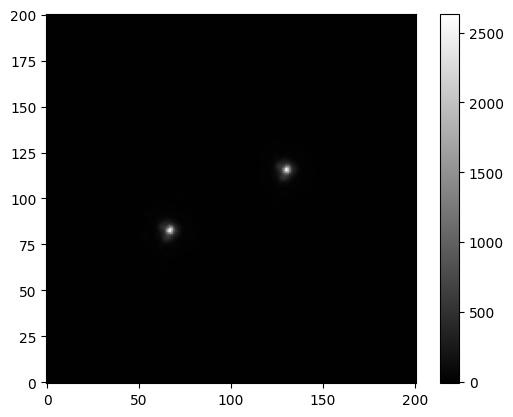

In [155]:
# Split the images into the wollaston beams
test_hdul = fits.open(fn)
image_data = (test_hdul[1].data)#[:,:,:99]
image_data_right = (test_hdul[1].data)[:,:,100:200]
#aperture.plot(color='red')
plt.imshow(image_data[12], origin='lower', cmap='gray')
plt.colorbar()
plt.show()

image_data=image_data

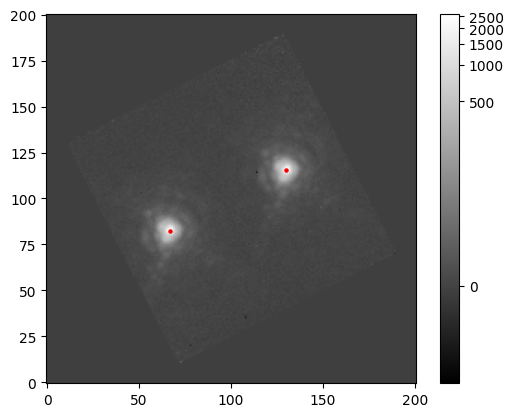

In [218]:
# Centroid the PSFs, test bin 12
test_data = image_data[12]
bgsub = test_data - np.median(test_data[120:134,37:63])
# x_r, y_r= centroid_com(r_bgsub[12])
# x_l,y_l= centroid_com(l_bgsub[12])
x_init = (66,132)
y_init = (81,115)
x,y = centroid_sources(bgsub,x_init,y_init,box_size=45,centroid_func=centroid_2dg)
snorm = simple_norm(bgsub,'log',)

plt.imshow(bgsub, origin='lower', cmap='grey',norm=snorm)
plt.colorbar()
plt.scatter(x,y,color='red', s=5)

# streamline into func
def charis_centroids_one_psf(image_data,initial_guess_l,initial_guess_r,box_size,plot_bin=None):
    """
    Fits centroids for CHARIS specpol mode using center of mass fit, assuming only one PSF per Wollaston beam.
    Fits all wavelength bins using an initial guess. Uses photutils centroid_sources()
    with centroid function centroid_com().

    Parameters
    -----------
    image_data: np.3darray
        CHARIS FITS cube image data. Axes should be (wavelength,y,x)
        Should be background subtracted.

    initial_guess_l: list or np.1darray
        Initial guess for the PSF centroid for the left beam.

    initial_guess_l: list or np.1darray
        Initial guess for the PSF centroid for the right beam.

    box_size: int
        Length of the square box where the algorithm will search for
        the PSF center. 
    
    plot_bin: int, optional
        Overlays centroids for specified bin on a log scale imshow plot if specified.

    
    Returns:
    --------

    centroids: np.3darray
        Array of 22 left and right beam centroids for 22 wavelength bins. 

    """

    centroids = []

    # Iterate through all bins
    for bin in range(0,22):
        image_data_bin_n = image_data[bin]

        # Grab initial guesses and calculate centroids
        x_init = (initial_guess_l[0],initial_guess_r[0])
        y_init = (initial_guess_l[1], initial_guess_r[1])
        x,y = centroid_sources(image_data_bin_n,x_init,y_init,box_size,centroid_func=centroid_com)
        centroid_list = [[x[0],y[0]],[x[1],y[1]]]
        centroids.append(centroid_list)

    centroids=np.array(centroids)   
    if plot_bin:
        # Overlay centroids on log stretched imshow plot 
        centroidbin_l = centroids[plot_bin,0,:]
        centroidbin_r = centroids[plot_bin,1,:]
        snorm = simple_norm(image_data[plot_bin],'log',)
        plt.imshow(image_data[plot_bin], origin='lower', cmap='inferno',norm=snorm)
        plt.colorbar()
        plt.scatter([centroidbin_l[0],centroidbin_r[0]],[centroidbin_l[1],centroidbin_r[1]],color='black', s=5, label='Centroid')

        plt.legend()

    return centroids








-0.016620583455754803


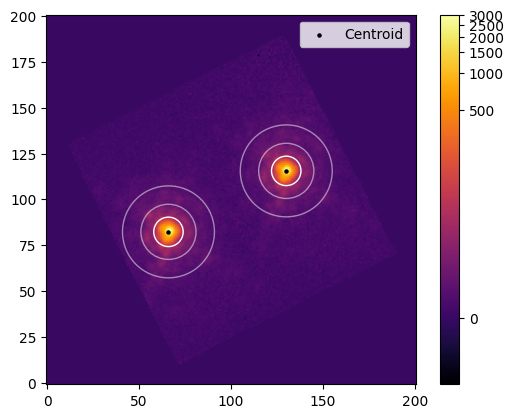

In [246]:
# Perform aperture photometry using a test bin

centroids = charis_centroids_one_psf(image_data,[65,83],[133,118],45,10)
test_centroid_l = centroids[10,0,:]
test_centroid_r = centroids[10,1,:]


# Define aperture at centroid
aperture_test_l = CircularAperture(test_centroid_l,r=8)
aperture_test_r = CircularAperture(test_centroid_r,r=8)

# Define annulus for background subtraction
annulus_test_l = CircularAnnulus(test_centroid_l,15,25)
annulus_test_r = CircularAnnulus(test_centroid_r,15,25)

annulus_test_l.plot(color='white',alpha=0.5)
annulus_test_r.plot(color='white',alpha=0.5)

aperture_test_l.plot(color='white')
aperture_test_r.plot(color='white')

# Calculate mean
aperstats_test_l = ApertureStats(image_data[10],annulus_test_l)
aperstats_test_r = ApertureStats(image_data[10],annulus_test_r)
mean_test_l = aperstats_test_l.mean
mean_test_r = aperstats_test_r.mean

# Perform aperture photometry
sum_test_l = aperture_photometry(image_data[10],aperture_test_l)['aperture_sum'][0] - mean_test_l
sum_test_r = aperture_photometry(image_data[10],aperture_test_r)['aperture_sum'][0] - mean_test_r

# Calculate single sums and differences
test_diff = sum_test_r-sum_test_l
test_sum = sum_test_l+sum_test_r

print(test_diff/test_sum)
